In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_6_gabas_ratio_'

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
from IPython.display import clear_output

import dill

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# print(mpl.rcParams.keys())


In [5]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 12.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 3.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0
############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

In [6]:
############################################################
#                       Functions                          #
############################################################



class LinearReg():

    def __init__(self, x, y):
        from sklearn.linear_model import LinearRegression

        self.lr_model = LinearRegression()

        self.x = x.reshape(-1, 1)
        self.y = y.reshape(-1, 1)

        self.lr_model.fit(self.x, self.y)

        self.rr = self.lr_model.score(self.x, self.y)

    def get_fitted_line(self):
        return [self.x, self.lr_model.predict(self.x)]

    def get_coefficients(self):
        return self.lr_model.coef_[0, 0], self.lr_model.intercept_[0]

    def get_score(self, x=0, y=0):
        if x == 0 or y == 0:
            return self.rr
        else:
            return self.lr_model.score(x, y)

    def print_coefficients(self):
        print('Gain: {0:1.2f}, Bias: {1:1.2f}, , r^2: {2:1.2f}'.format(self.lr_model.coef_[0, 0], self.lr_model.intercept_[0], self.rr))
        return ('Gain: {0:1.2f},\nBias: {1:1.2f},\n' + r'$r^2$: {2:1.2f}').format(self.lr_model.coef_[0, 0], self.lr_model.intercept_[0], self.rr)


#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.minimum(np.maximum(q_pc,0),1)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # default gaba inhibiton
#     gaba_inh += 0.20
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = convolve1d(s_sbc,weights=ee_kernel,axis=0,mode='reflect')*(1-gaba_exc)
    # calculate inhibitor input, which comes from the q_pc folded by the E-I kernel
    inhibitory_in = convolve1d(g_q_out(q_pc),weights=ei_kernel,axis=0,mode='reflect')*(1-gaba_inh)     
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = convolve1d(s_gbc,weights=ie_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = convolve1d(g_q_out(q_pc_all),weights=ii_kernel,axis=0,mode='reflect')     
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Input

In [7]:

# GABA parameter
gaba_inh = np.linspace(0.0,1,41)
gaba_exc = np.linspace(0.0,1,41)



sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)


# store values for different parameters
q_all = np.zeros((len(gaba_inh),len(gaba_exc),len(t),freq_bands))
r_all = np.zeros((len(gaba_inh),len(gaba_exc),len(t),freq_bands))



############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,:] = (i)/(len(t)-time_window) * gbc_input_strength


# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 1.0

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,:] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength



gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')
gauss_mask = gauss(np.linspace(-50,50,5000),0,1)
s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='reflect')
############################################################
#                      Simulation                          #
############################################################


for k in range(len(gaba_inh)):
    for l in range(len(gaba_exc)):
    
       



        # correct for border effect of convolve
        s_gbc_all[-250:,:] = np.max(s_gbc_all[-250:])
        s_sbc_all[:250,:] = np.max(s_sbc_all[:250])


        for i in range(0, len(t)-1):
            
            r_all[l,k,i+1,:] = r_all[l,k,i,:] +  dt * ode_r_bpc(r_all[l,k,i,:],s_sbc_all[i],ee_kernel,q_all[l,k,i,:],ei_kernel,gaba_exc[l],gaba_inh[k])             

            q_all[l,k,i+1,:] = q_all[l,k,i,:] +  dt * ode_q_pc(q_all[l,k,i,:],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

        clear_output(wait=True)
        print(k,l)


40 40


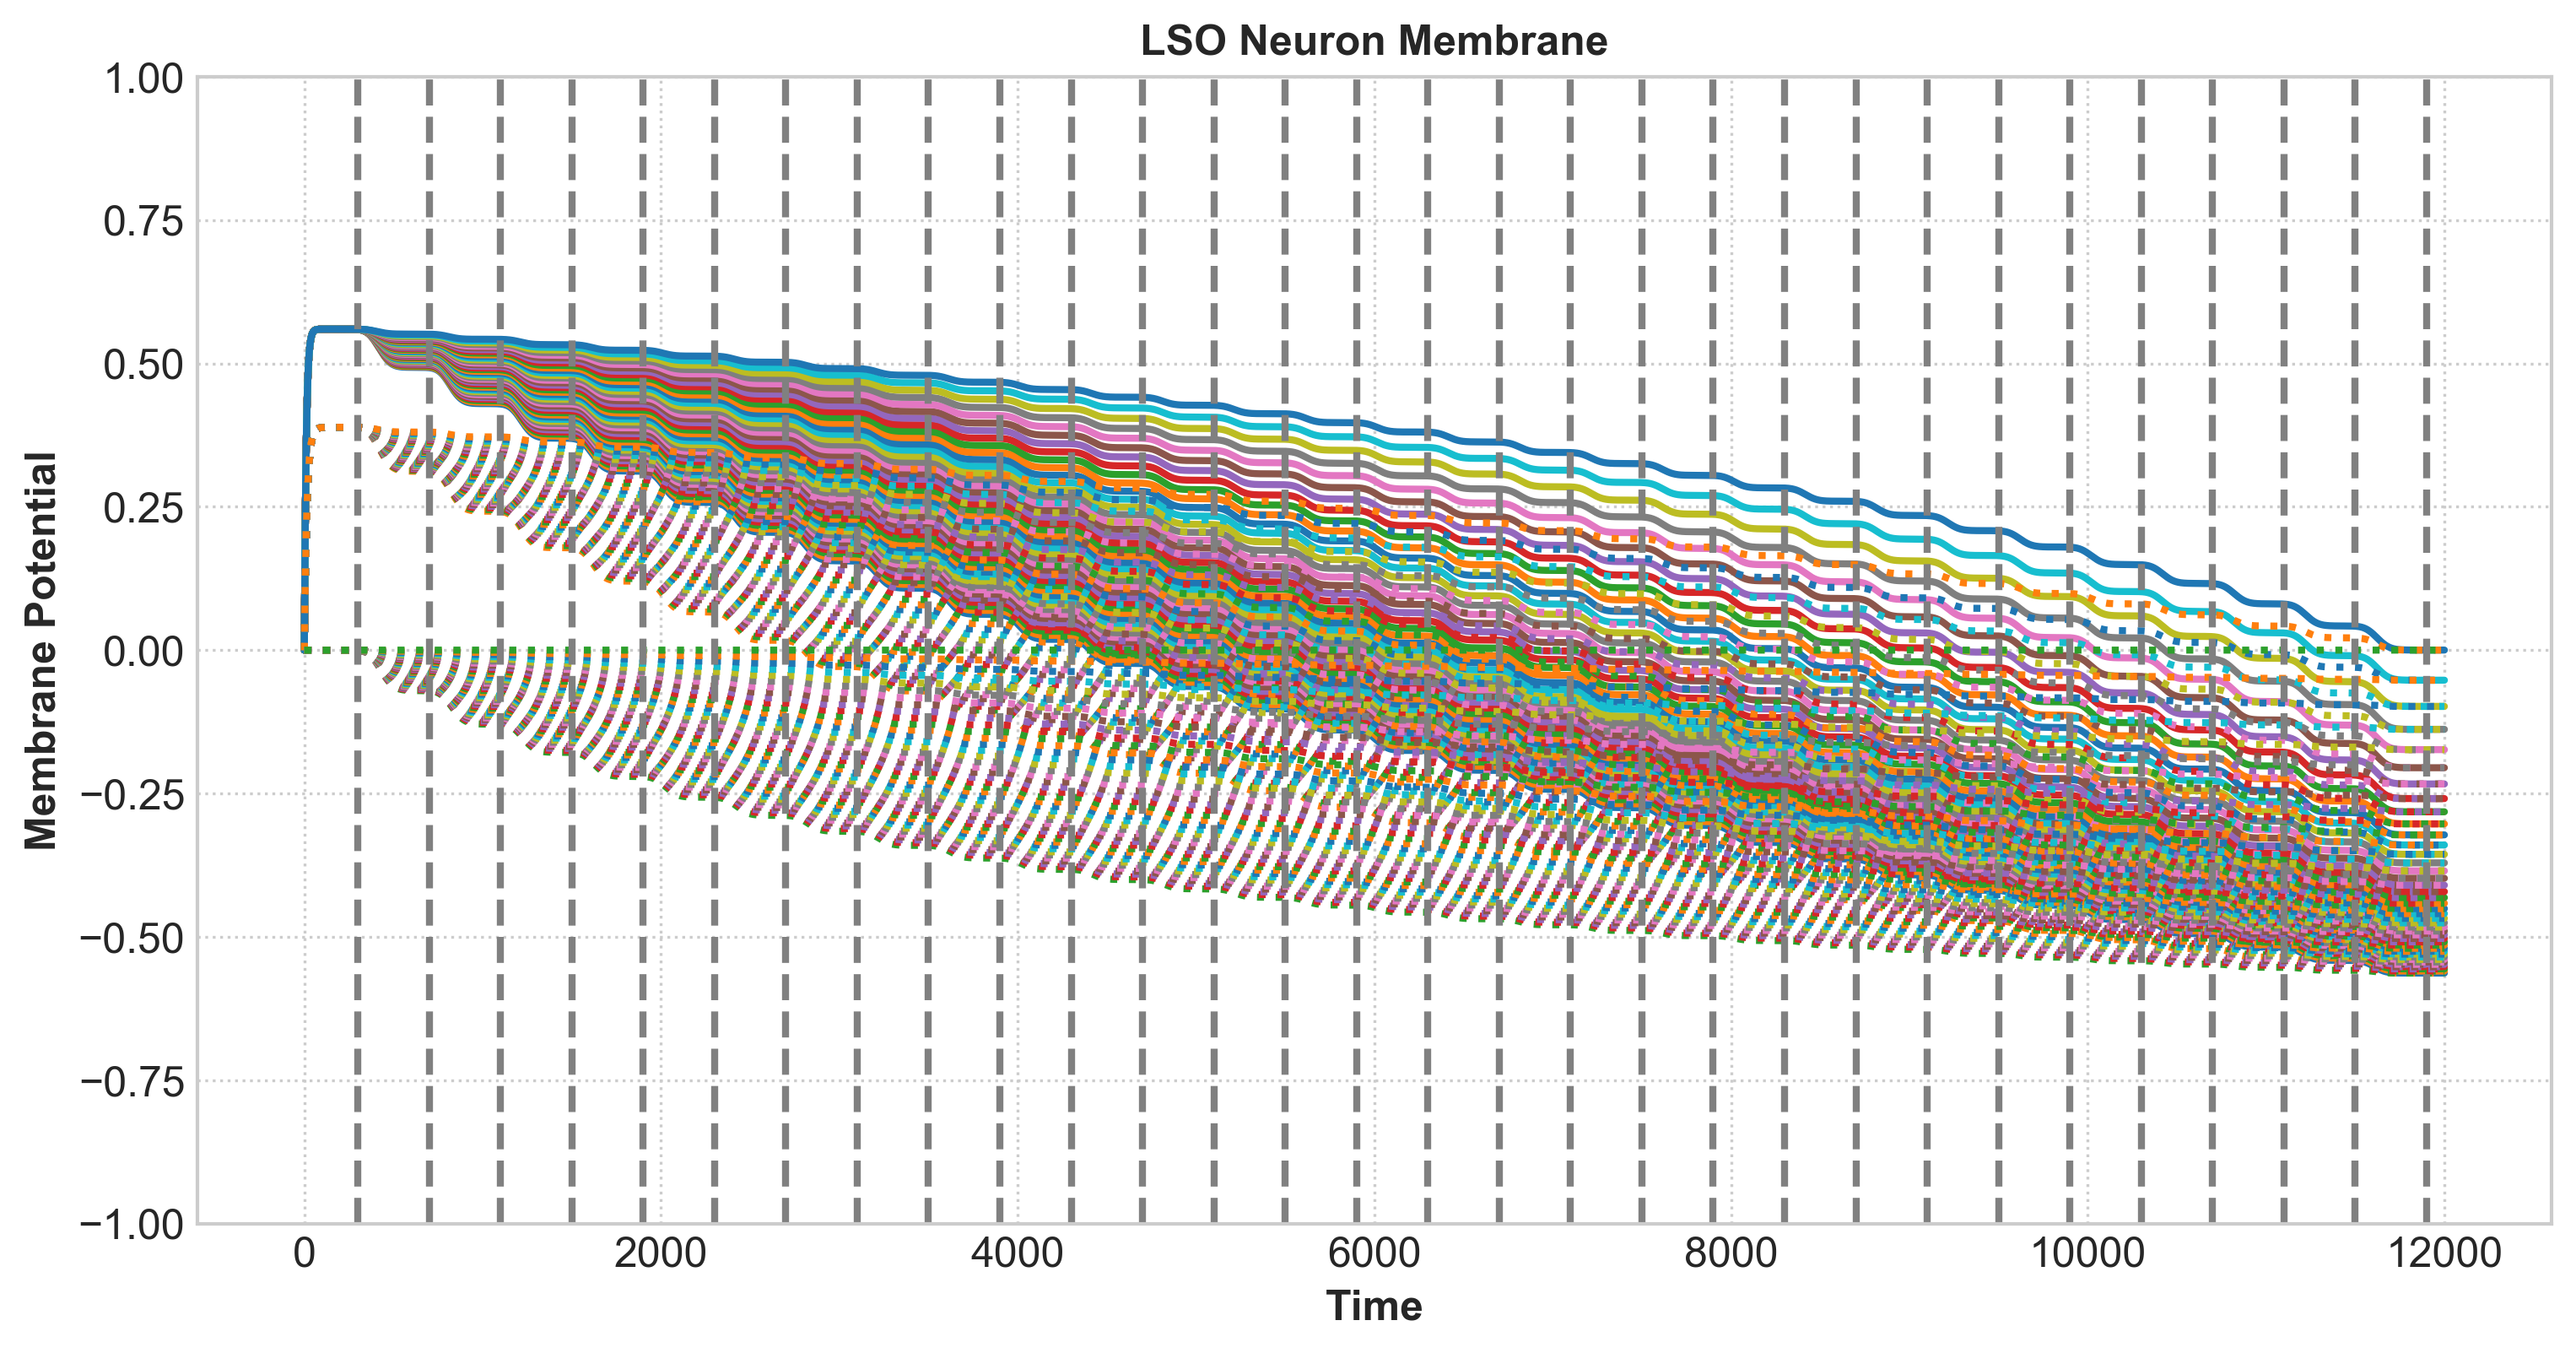

In [8]:
# Define the times when to probe
probing_times = [1750]
probing_times = np.arange(300,len(t),time_window)

# show LSO neuron membrane
# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]
q = q_all[:,:,:,sbc_center_frequencyBand]
fig = plt.figure(figsize=(12,6))
ax2 = fig.add_subplot(111)
for j in range(0,r.shape[0],20):
    if j == 0:
        line_style = '-'
    elif j == 1:
        line_style = '--'
    else:
        line_style = ':'

    for i in range(0,r.shape[1]):
        plt.plot(r[j,i,:],linestyle=line_style)
for i in probing_times:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Membrane')
plt.xlabel('Time')
plt.ylabel('Membrane Potential')
plt.ylim([-1.0,1])
plt.show()

No handles with labels found to put in legend.


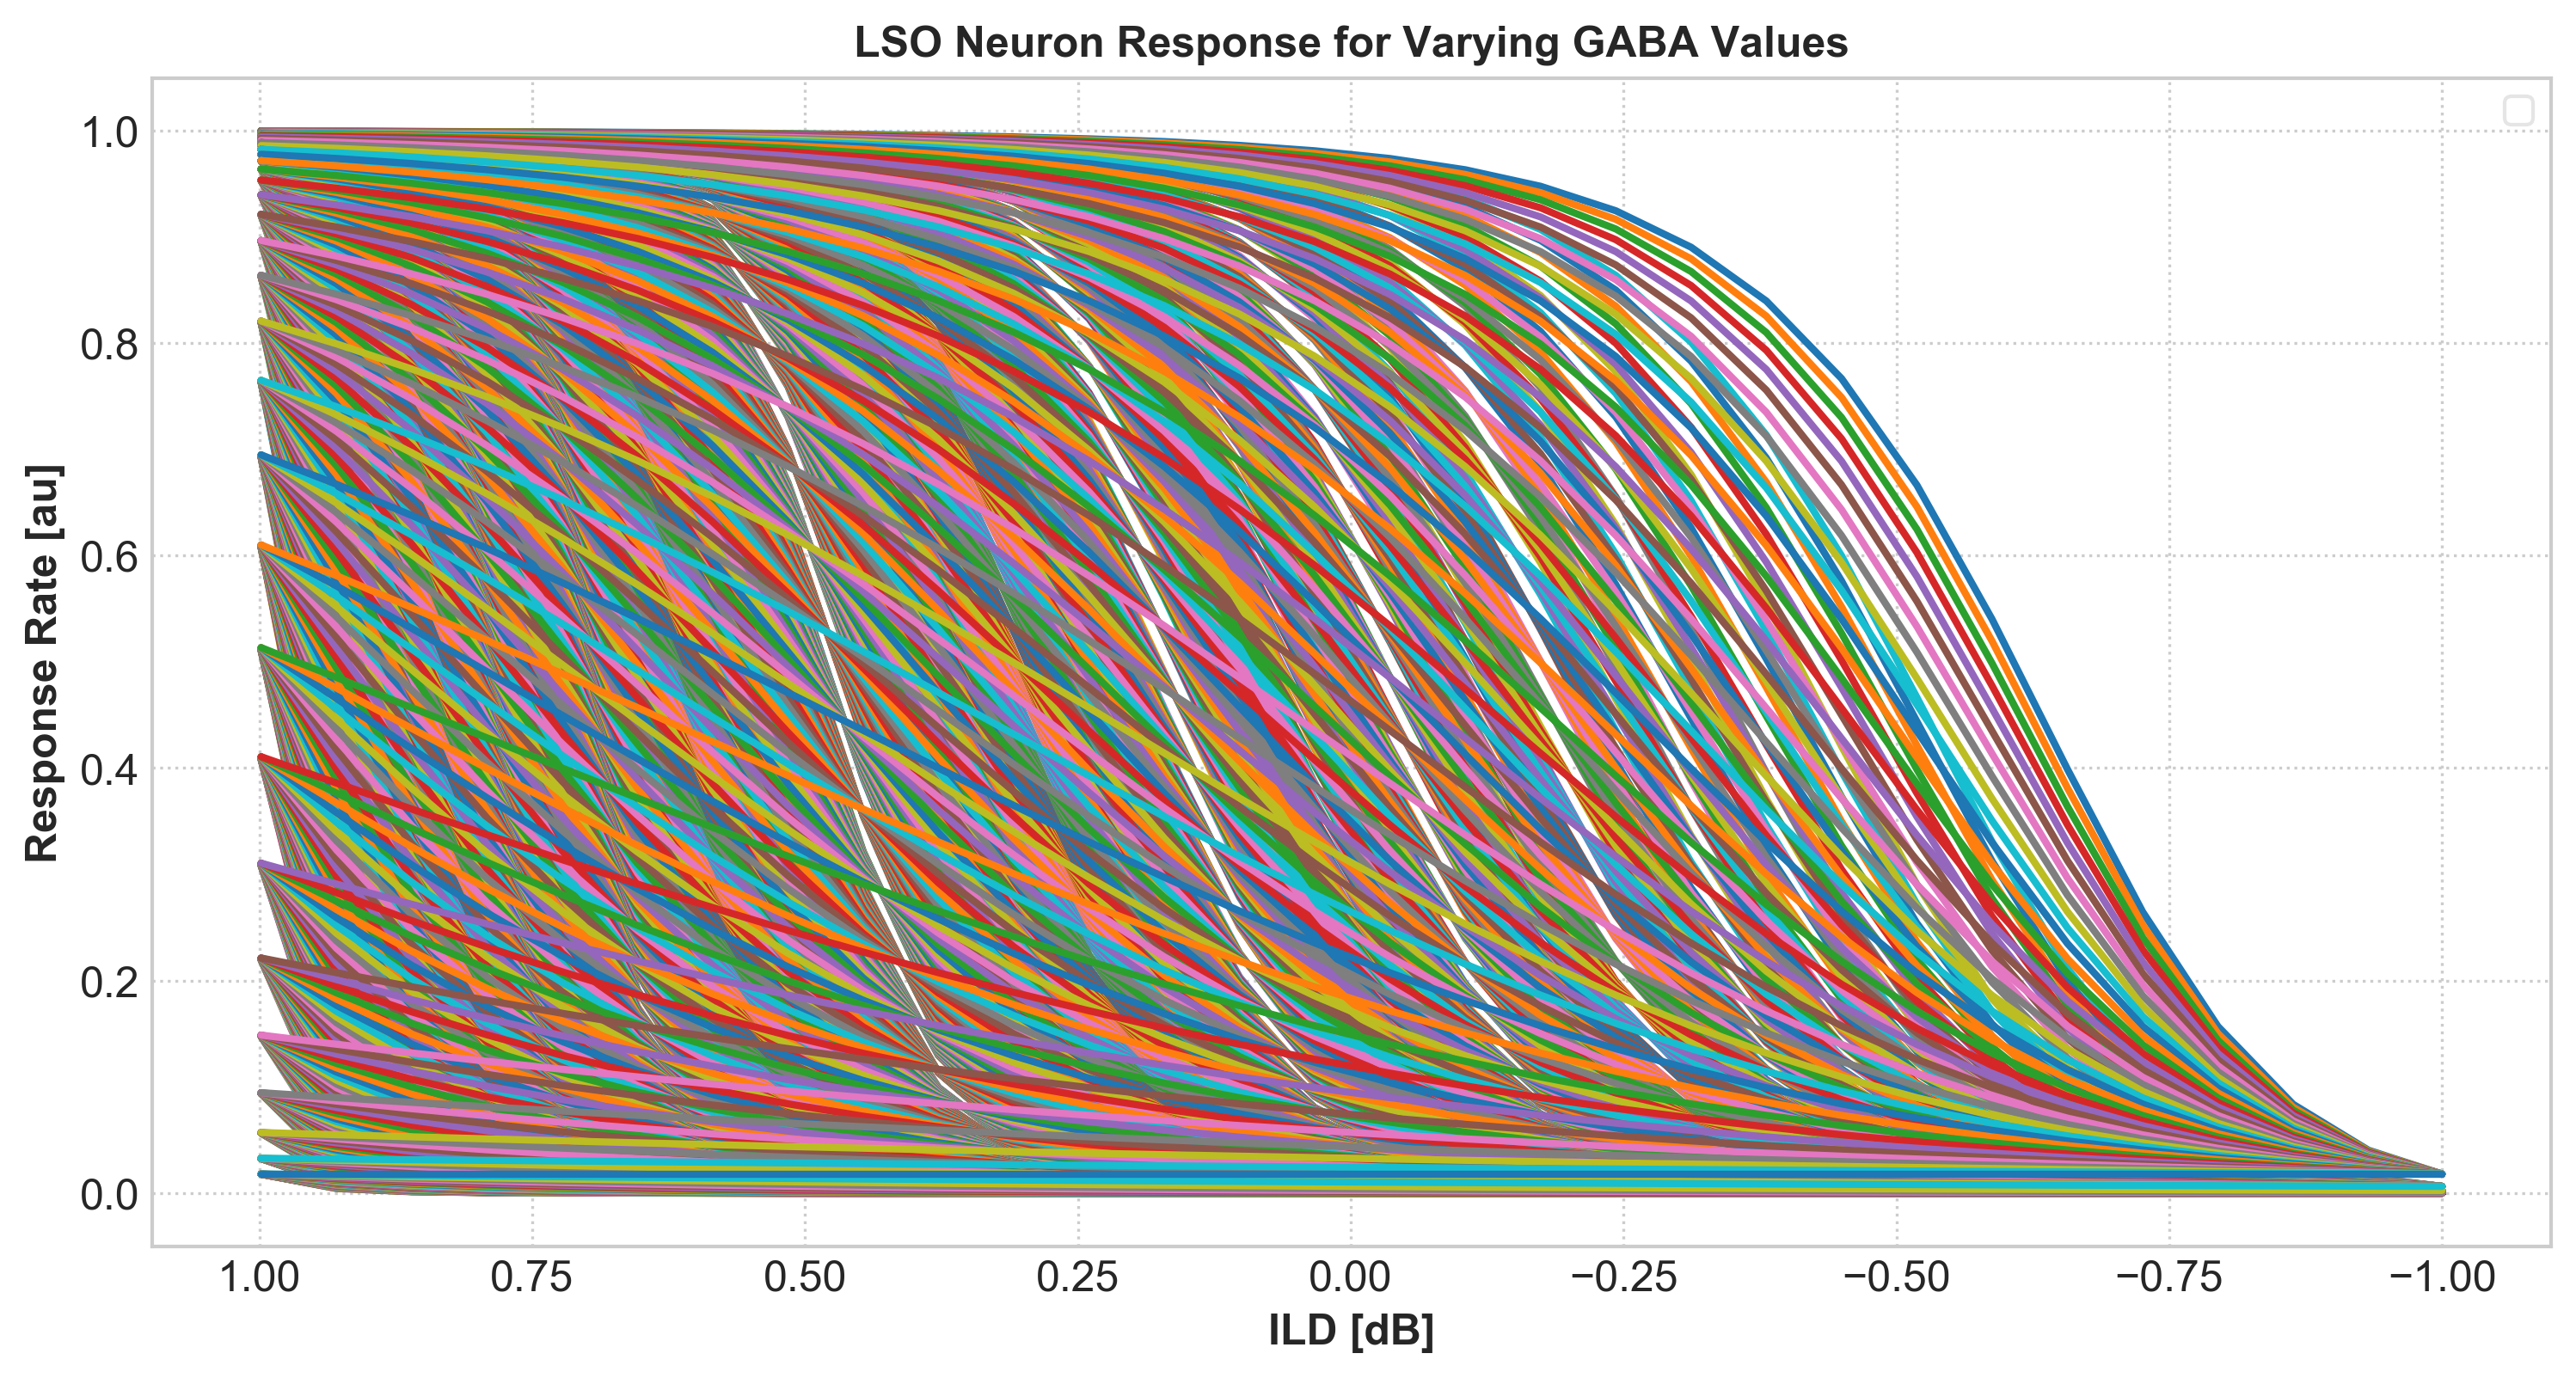

In [9]:
# Define the times when to probe
diff_input =  s_sbc_all-s_gbc_all
diff_input = diff_input[:,sbc_center_frequencyBand]
r = r_all[:,:,:,sbc_center_frequencyBand]

fig = plt.figure(figsize=(12,6))

## show LSO neuron response
ax2 = fig.add_subplot(111)
for i in range(0,r.shape[0]):
    for j in range(0,r.shape[1]):
        tmp = g_r_out(r[i,j,probing_times])
        # normalize it
    #     tmp = tmp -  np.min(tmp)
    #     tmp = tmp / np.max(tmp)
        ax2.plot(diff_input[probing_times],tmp,linestyle='-')
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
ax2.invert_xaxis()
plt.title('LSO Neuron Response for Varying GABA Values')
plt.xlabel('ILD [dB]')
plt.ylabel('Response Rate [au]')
# ax2.set_xticklabels(ax2.get_xticks()*100)

lgd = plt.legend()

plt.show()




0.8076923076923076 -0.06660412757973731
3


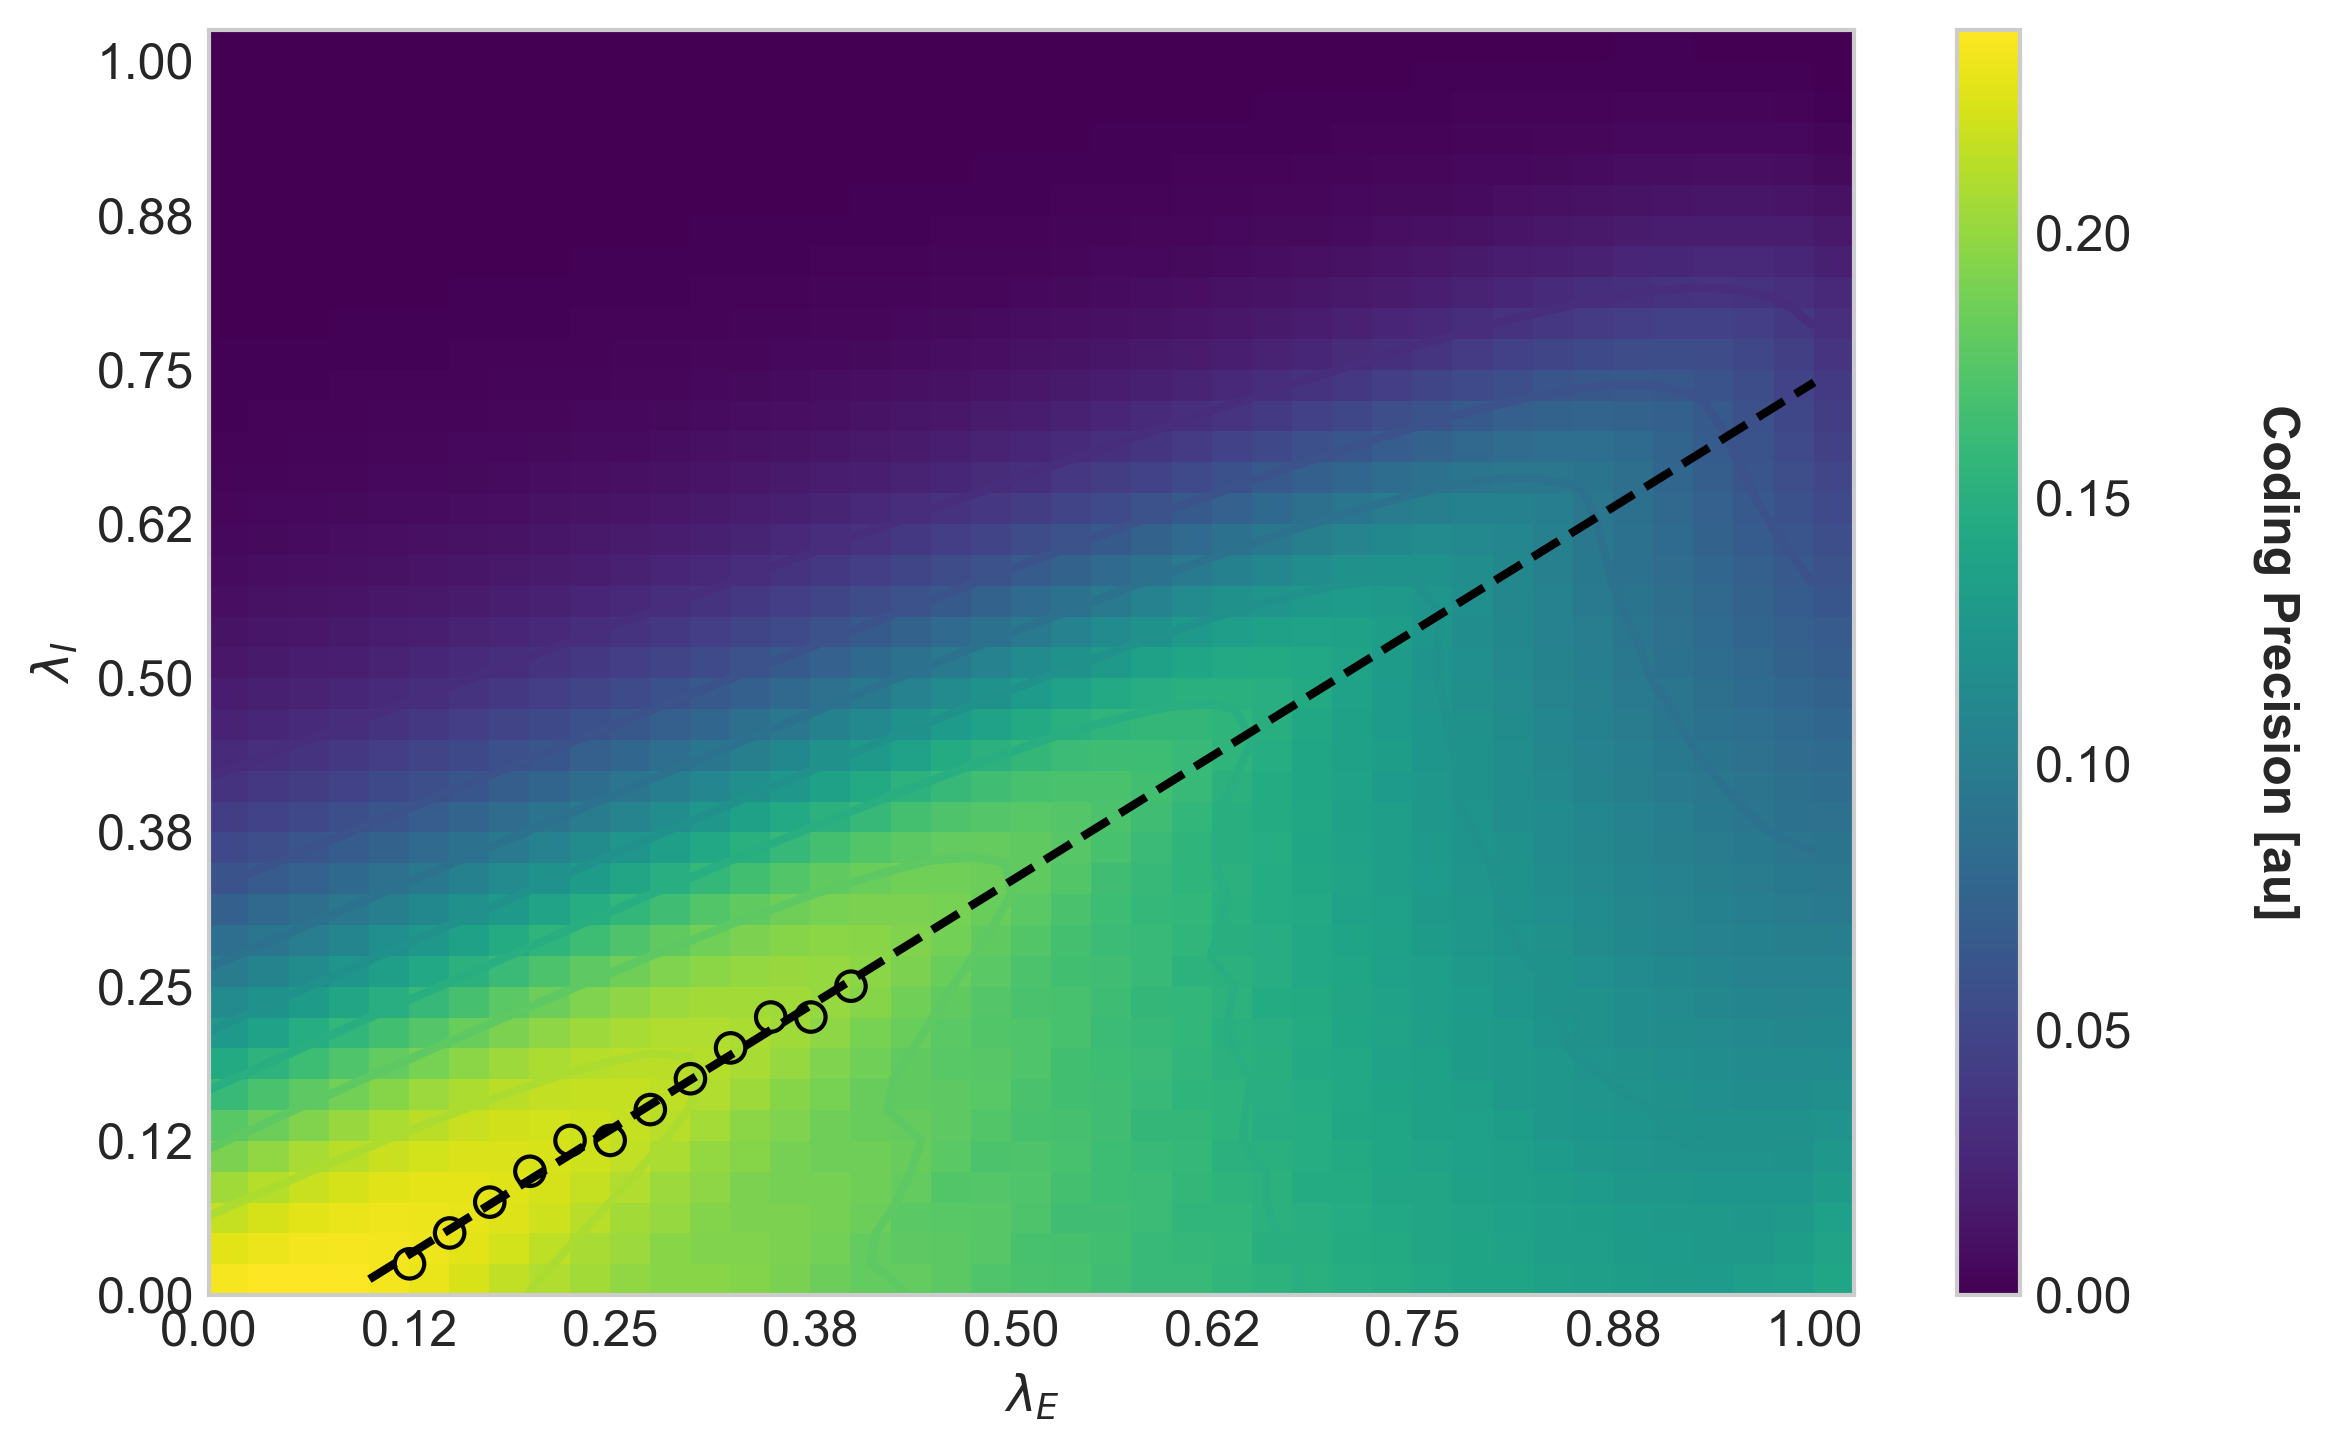

In [7]:
fig = plt.figure()
# ax2 = fig.add_subplot(111,projection='3d')
ax2 = fig.add_subplot(111)

## show LSO neuron response
# probing_times = np.arange(1900,len(t)-1900,time_window)
probing_times = np.arange(2700,len(t)-1800,time_window)
# probing_times = 5000
tmp = -np.array(np.gradient(g_r_out(r[:,:,probing_times]),axis = 2))


# maxi_arg = np.squeeze(np.argmax(tmp,axis=2))
maxi = np.squeeze(np.max(tmp,axis=2))
                     

c = ax2.pcolormesh(maxi[:,:],cmap='viridis', zorder=-2)
ax2.contour(maxi,cmap='viridis', zorder=-1)
data_peaks = np.zeros((maxi.shape[0]-24))
data_peaks_i = np.zeros((maxi.shape[0]-24))

# use the gradien to calculate the peaks
grad,_ = np.gradient(maxi)

for i in range(maxi.shape[0]-24):
    data_peaks[i] = np.argmax(maxi[:,i])
    data_peaks_i[i] = i
    if data_peaks[i] <= 0:
        data_peaks[i] = np.NaN
        data_peaks_i[i] = np.NaN

    ax2.scatter(data_peaks_i[i],data_peaks[i],s=50,linewidth=1,facecolors='none',color= 'black', zorder=1)
#     print(np.argmax(maxi[:,i]))
# calculate linear regression function for peak points (walk on the ridghe of the hill)
data_peaks = data_peaks[np.invert(np.isnan(data_peaks))]
data_peaks_i = data_peaks_i[np.invert(np.isnan(data_peaks_i))]

if len(data_peaks)>1:
    lr = LinearReg(data_peaks_i,data_peaks)
    [x,y] = lr.get_fitted_line()
    [g,b] = lr.get_coefficients()
    print(g,b/len(gaba_inh))
#     plt.plot(x,y)
    x_range = np.arange(0,41)
    y_range = lr.lr_model.predict(x_range.reshape(-1,1))
    
    #remove values below y=0
    ind = np.argmin(np.abs(y_range))
    print(ind)

    ax2.plot(x_range[ind+1:],y_range[ind+1:],color= 'black', linestyle = '--', zorder=1)
#     ax2.annotate("Gain : {0:0.2f}".format(fit_fn[1]), xy=(maxi.shape[0]/2, 15), xytext=(maxi.shape[0]/2-7, 10))
#     ax2.annotate("Bias : {0:0.2f}".format(fit_fn[0]/len(gaba_inh)), xy=(maxi.shape[0]/2, 15), xytext=(maxi.shape[0]/2-7, 20))

# ax2.hlines(30*0.38,0,30)

cbar = plt.colorbar(c)
cbar.set_label('Coding Precision [au]', rotation=270, labelpad=40,)

# ax2.set_title('Coding Precision for Various GABA Value Ratios')
ax2.set_xlabel(r'$\lambda_E$',fontsize=12)
ax2.set_ylabel(r'$\lambda_I$',fontsize=12)


# print(fit_fn[0]/41)
# print(gaba_inh[8])
ax2.set_xlim([0,41])

ax2.set_yticklabels(['{0:.2f}'.format(k) for k in np.linspace(0,1,len(ax2.get_yticks())-1)])
ax2.set_xticklabels(['{0:.2f}'.format(k/(maxi.shape[0]-1)) for k in ax2.get_xticks()])

plt.tight_layout()

plt.savefig(figure_name + 'plot.svg', bbox_inches='tight')
plt.savefig(figure_name + 'plot.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'plot.tiff', bbox_inches='tight')


plt.show()

In [1]:
import dill
# dill.dump_session('fig_6_3_gaba_strength_plot')
# dill.load_session('fig_6_3_gaba_strength_plot')